In [30]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import matplotlib.pyplot as plt

In [31]:
def mse(y , yhat):
    r = yhat - y
    return float(np.mean(r * r))

def loss_half_mse(X , y , w):
    r = X @ w - y
    return 0.5 * float(np.mean(r * r))

def grad_half_mse(X , y , w):
    # gradient of (1/2n)||Xw - y||^2 is (1/n) X^T (Xw - y)
    n = X.shape[0]
    return (X.T @ (X @ w - y)) / n

def standardize_by_train(X_tr , X_va , X_te):
    mu = X_tr.mean(axis = 0)
    sd = X_tr.std(axis = 0 , ddof = 0)
    sd[sd == 0] = 1.0
    return (X_tr - mu) / sd , (X_va - mu) / sd , (X_te - mu) / sd

def center_by_train(y_tr , y_va , y_te):
    m = y_tr.mean()
    return y_tr - m , y_va - m , y_te - m

def downsample_idx(n , max_points = 70):
    if n <= max_points:
        return np.arange(n)
    return np.linspace(0 , n - 1 , max_points).astype(int)

In [32]:
#==============================================
# Gradient Descent (with early-stop on stall)
#==============================================
def run_gd(X_tr , y_tr , X_va , y_va , lr , max_iters = 250 , rel_tol = 1e-9 , patience = 8 , blowup = 1e12 , track_pair = (72 , 20)):
    p = X_tr.shape[1]
    w = np.zeros(p)

    tr_hist = []
    va_hist = []
    pair_hist = []

    prev = loss_half_mse(X_tr , y_tr , w)
    stall = 0

    last_safe_w = w.copy()
    last_safe_pair_hist = []

    for t in range(max_iters):
        g = grad_half_mse(X_tr , y_tr , w)
        w = w - lr * g

        tr = loss_half_mse(X_tr , y_tr , w)
        va = loss_half_mse(X_va , y_va , w)

        tr_hist.append(tr)
        va_hist.append(va)
        pair_hist.append((w[track_pair[0]] , w[track_pair[1]]))

        if np.isfinite(tr) and tr < blowup:
            last_safe_w = w.copy()
            last_safe_pair_hist = list(pair_hist)

        # Stop if it explodes
        if (not np.isfinite(tr)) or (tr >= blowup):
            break

        rel_impr = abs(prev - tr) / max(abs(prev) , 1e-12)
        if rel_impr < rel_tol:
            stall += 1
        else:
            stall = 0
        prev = tr

        if stall >= patience:
            break

    w_out = last_safe_w
    pair_out = np.array(last_safe_pair_hist if len(last_safe_pair_hist) else pair_hist , dtype = float)

    return {
        "w": w_out , "iters": len(tr_hist) , "train_loss": np.array(tr_hist , dtype = float) ,
        "val_loss": np.array(va_hist , dtype = float) , "pair_path": pair_out ,
    }

In [33]:
#====================
# 2D Geometry slice
#====================
def plot_gd_geometry_2d(ax , X_tr , y_tr , path_xy , title , w_base = "zeros" , levels = 12):
    x_path = path_xy[ : , 0]
    y_path = path_xy[ : , 1]

    # Contour box based on start/end
    x0 , y0 = x_path[0] , y_path[0]
    x1 , y1 = x_path[-1] , y_path[-1]
    xmin = min(np.min(x_path) , x0 , x1)
    xmax = max(np.max(x_path) , x0 , x1)
    ymin = min(np.min(y_path) , y0 , y1)
    ymax = max(np.max(y_path) , y0 , y1)

    padx = 0.25 * max(1e-6 , (xmax - xmin))
    pady = 0.25 * max(1e-6 , (ymax - ymin))
    xmin , xmax = xmin - padx , xmax + padx
    ymin , ymax = ymin - pady , ymax + pady

    # 2D quadratic slice when w_base = 0:
    # loss(a , b) = 0.5 * E[(-y + a * xi + b * xj) ^ 2]
    xi = X_tr[ : , i_idx]
    xj = X_tr[ : , j_idx]
    r = -y_tr

    c0 = np.mean(r * r)
    c1 = np.mean(r * xi)
    c2 = np.mean(r * xj)
    a2 = np.mean(xi * xi)
    b2 = np.mean(xj * xj)
    ab = np.mean(xi * xj)

    grid_n = 180
    xs = np.linspace(xmin , xmax , grid_n)
    ys = np.linspace(ymin , ymax , grid_n)
    A , B = np.meshgrid(xs , ys)

    Z = 0.5 * (c0 + 2 * A * c1 + 2 * B * c2 + (A * A) * a2 + (B * B) * b2 + 2 * A * B * ab)

    zmin = float(np.min(Z))
    zmax = float(np.quantile(Z , 0.98))
    zmax = max(zmax , zmin + 1e-9)
    lev = np.geomspace(zmin + 1e-9 , zmax , levels)

    cs = ax.contour(A , B , Z , levels = lev , linewidths = 1.2)
    _ = ax.clabel(cs , inline = True , fontsize = 8 , fmt = "%.3g")

    keep = downsample_idx(len(x_path) , max_points = 60)
    xp , yp = x_path[keep] , y_path[keep]

    _ = ax.plot(xp , yp , marker = "o" , markersize = 4 , linewidth = 2)
    _ = ax.scatter([x0] , [y0] , s = 70 , marker = "o" , edgecolors = "white" , linewidths = 1.2 , zorder = 5)
    _ = ax.scatter([x1] , [y1] , s = 90 , marker = "X" , edgecolors = "white" , linewidths = 1.2 , zorder = 6)

    _ = ax.annotate("start" , xy = (x0 , y0) , xytext = (8 , 8) , textcoords = "offset points" ,
                    bbox = dict(boxstyle = "round , pad = 0.25" , alpha = 0.25))
    _ = ax.annotate("end" , xy = (x1 , y1) , xytext = (8 , -16) , textcoords = "offset points" ,
                    bbox = dict(boxstyle = "round , pad = 0.25" , alpha = 0.25))

    _ = ax.set_title(title)
    _ = ax.set_xlabel(f"w[{i_idx}]")
    _ = ax.set_ylabel(f"w[{j_idx}]")
    _ = ax.set_xlim(xmin , xmax)
    _ = ax.set_ylim(ymin , ymax)
    _ = ax.grid(alpha = 0.15)

In [34]:
#==============
# Weights plot
#==============
def stem_weights(ax , w , title):
    p = len(w)
    x = np.arange(p)
    markerline , stemlines , baseline = ax.stem(x , w)
    _ = ax.set_title(title)
    _ = ax.set_xlabel("Feature index")
    _ = ax.set_ylabel("Weight")

    try:
        stemlines.set_linewidth(1.0)
    except Exception:
        pass

    lim = float(np.quantile(np.abs(w) , 0.99))
    lim = max(lim , 1e-6)
    _ = ax.set_ylim(-1.15 * lim , 1.15 * lim)
    _ = ax.grid(alpha = 0.12)

In [35]:
plt.style.use("dark_background")
rng = np.random.default_rng(7)
n , p , k = 900 , 200 , 8
X = rng.normal(0.0 , 1.0 , size = (n , p))
true_idx = rng.choice(p , size = k , replace = False)
w_true = np.zeros(p)
signs = rng.choice([-1.0 , 1.0] , size = k)
mags = rng.uniform(1.5 , 3.5 , size = k)
w_true[true_idx] = signs * mags
noise = rng.normal(0.0 , 1.0 , size = n)
y = X @ w_true + noise

In [36]:
perm = rng.permutation(n)
n_tr = int(0.60 * n)
n_va = int(0.20 * n)
tr_id = perm[ : n_tr]
va_id = perm[n_tr : n_tr + n_va]
te_id = perm[n_tr + n_va : ]
X_tr , X_va , X_te = X[tr_id] , X[va_id] , X[te_id]
y_tr , y_va , y_te = y[tr_id] , y[va_id] , y[te_id]
X_tr , X_va , X_te = standardize_by_train(X_tr , X_va , X_te)
y_tr , y_va , y_te = center_by_train(y_tr , y_va , y_te)
lrs = {"slow": 7.01e-02 , "good": 4.67e-01 , "too-big": 9.44e-01}
i_idx , j_idx = 72 , 20
results = {}

In [37]:
for name , lr in lrs.items():
    res = run_gd(
        X_tr , y_tr , X_va , y_va , lr = lr , max_iters = 250 , rel_tol = 1e-9 ,
        patience = 8 , blowup = 1e12 , track_pair = (i_idx , j_idx) ,
    )
    results[name] = res

    w_hat = res["w"]
    tr_mse = mse(y_tr , X_tr @ w_hat)
    va_mse = mse(y_va , X_va @ w_hat)
    te_mse = mse(y_te , X_te @ w_hat)

    print(f"GD ({name:1s}) lr = {lr:.2e}  iters = {res['iters']:3d}  "
          f"train MSE = {tr_mse:.3f}  val MSE = {va_mse:.3f}  test MSE = {te_mse:.3f}")

nnz_true = int(np.sum(np.abs(w_true) > 0))
nnz_gd = int(np.sum(np.abs(results["good"]["w"]) > 1e-12))
print(f"True sparsity -> non-zero true features: {nnz_true} | "
      f"GD solution is dense by default (no L1): nnz = {nnz_gd} / {p}")

GD (slow) lr = 7.01e-02  iters = 250  train MSE = 0.619  val MSE = 1.516  test MSE = 1.636
GD (good) lr = 4.67e-01  iters = 116  train MSE = 0.618  val MSE = 1.557  test MSE = 1.652
GD (too-big) lr = 9.44e-01  iters =  53  train MSE = 1131050454017.641  val MSE = 470506604816.370  test MSE = 434453682723.920
True sparsity -> non-zero true features: 8 | GD solution is dense by default (no L1): nnz = 200 / 200


(0.1, 100)

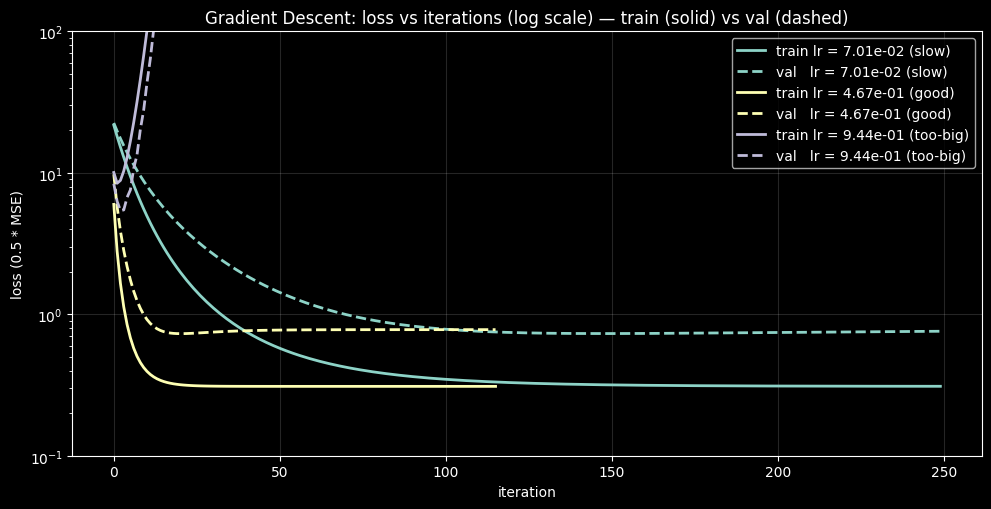

In [38]:
#=====================================================================
# loss vs iterations plot (log scale) — train (solid) vs val (dashed)
#=====================================================================
fig1 , ax1 = plt.subplots(figsize = (10 , 5.2))
_ = ax1.set_title("Gradient Descent: loss vs iterations (log scale) — train (solid) vs val (dashed)")
_ = ax1.set_xlabel("iteration")
_ = ax1.set_ylabel("loss (0.5 * MSE)")
_ = ax1.set_yscale("log")
_ = ax1.grid(alpha = 0.15)

for name , lr in lrs.items():
    tr = results[name]["train_loss"]
    va = results[name]["val_loss"]
    it = np.arange(len(tr))

    line_tr , = ax1.plot(it , tr , linewidth = 2 , label = f"train lr = {lr:.2e} ({name})")
    ax1.plot(it , va , linewidth = 2 , linestyle = "--" , color = line_tr.get_color() ,
             label = f"val   lr = {lr:.2e} ({name})")

_ = ax1.legend(loc = "upper right")
fig1.tight_layout()
plt.ylim(0.1 , 100)
plt.show()

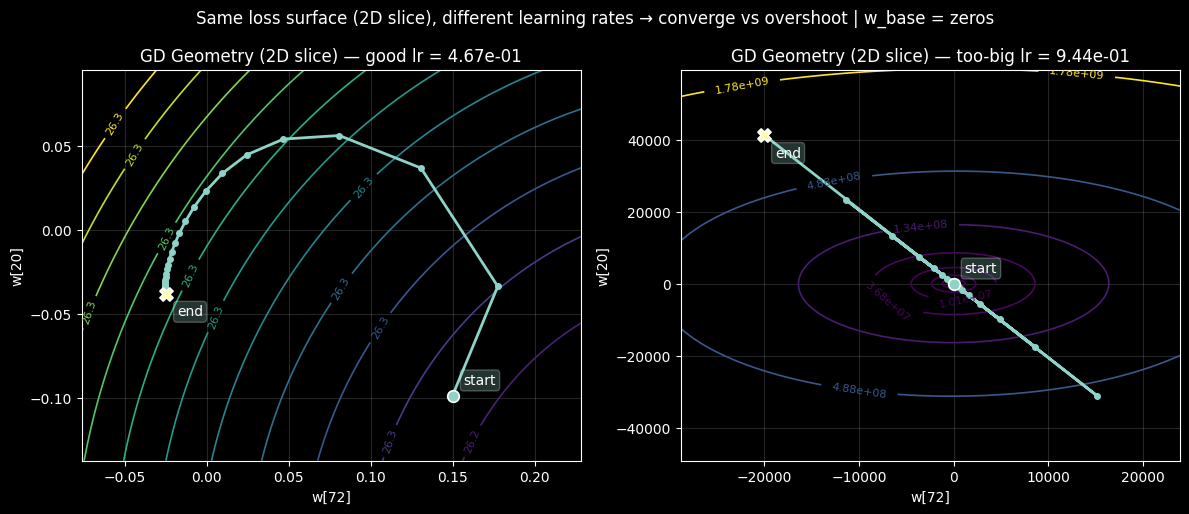

In [39]:
#=============================
# GD geometry (2D slice) plot
#=============================
fig2 , (ax2a , ax2b) = plt.subplots(1 , 2 , figsize = (12 , 5.2) , sharex = False , sharey = False)
_ = fig2.suptitle("Same loss surface (2D slice), different learning rates → converge vs overshoot | w_base = zeros")

plot_gd_geometry_2d(
    ax2a , X_tr , y_tr , path_xy = results["good"]["pair_path"] , w_base = "zeros" ,
    title = f"GD Geometry (2D slice) — good lr = {lrs['good']:.2e}" , levels = 12 ,
)
plot_gd_geometry_2d(
    ax2b , X_tr , y_tr , path_xy = results["too-big"]["pair_path"] , w_base = "zeros" ,
    title = f"GD Geometry (2D slice) — too-big lr = {lrs['too-big']:.2e}" , levels = 12 ,
)
fig2.tight_layout()
plt.show()

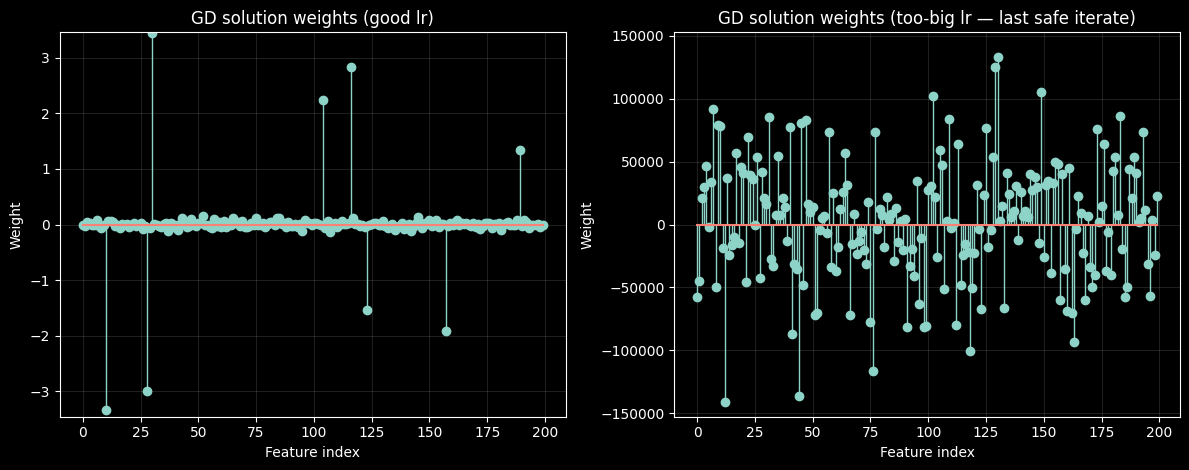

In [40]:
#==========================
# GD solution weights plot
#==========================
fig3 , (ax3a , ax3b) = plt.subplots(1 , 2 , figsize = (12 , 4.8))
stem_weights(ax3a , results["good"]["w"] , "GD solution weights (good lr)")
stem_weights(ax3b , results["too-big"]["w"] , "GD solution weights (too-big lr — last safe iterate)")
fig3.tight_layout()
plt.show()